# Experimental results 4: meta RL experiments with Garage

We use the [garage library](https://github.com/rlworkgroup/garage) to evaluate some of the popular meta RL algorithms on our problems. In particular, we test *MAML-TPRO*, *RL*$^2$ and *PEARL*.


## Installation

Start by installing the garage package [as advised on their docs](https://garage.readthedocs.io/en/latest/user/installation.html). Note that as garage is not longer very actively maintained, installing it can be a bit tricky. Here are some tips for debugging:

1. Use Python 3.7 -> anything above has thrown errors for us about packages not resolving.
2. Really ensure that mujoco is installed correctly (and on the correct path, although this is needed only for testing installation).
3. You may need to install patchelf [as described here](https://github.com/openai/mujoco-py/issues/652>).


## Garage experiments

Next, we run the actual experiments using the experiment scripts provided in `bauwerk/baselines`. Assuming this notebook is run out of its directory in the repo, you can run the experiment using:

In [ ]:
! python ../../baselines/maml.py --epochs=1

In [ ]:
! python ../../baselines/pearl.py --num_epochs=10

In [ ]:
! python ../../baselines/rl2_ppo_tf.py --n_epochs=2

## Plotting

Given the completion of all the above experiments, we can now move on to plot the results.

In [1]:
import matplotlib.pyplot as plt

# Setup and helper code
import bauwerk
import bauwerk.eval
import bauwerk.benchmarks
from bauwerk.utils.garage import DEFAULT_EPISODE_LEN
import gym
import numpy as np

# The length of each task
TASK_LEN = DEFAULT_EPISODE_LEN

In [2]:
# Get log files for all experiments
import pathlib
from tensorboard.backend.event_processing import event_accumulator

exp_dir = pathlib.Path("./data/local/experiment/")

def get_first_exp_log(algorithm_name):
    folder = [exp_file for exp_file in exp_dir.iterdir() if algorithm_name in str(exp_file)][0]
    events_file_name = [exp_file for exp_file in folder.iterdir() if "events.out" in str(exp_file)][0]
    return str(events_file_name.absolute())

algs = ["maml","rl2_ppo","pearl"]
pretty_alg_names = list(zip(algs, ["MAML-TRPO", "RL$^2$", "PEARL"]))
tensorboard_eas = {key: event_accumulator.EventAccumulator(get_first_exp_log(key)) for key in algs}
# load all the data
tensorboard_eas = {name: ea.Reload() for name, ea in tensorboard_eas.items()}



2023-02-08 14:38:02.157298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 14:38:03.150912: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/af691/.mujoco/mujoco210/bin
2023-02-08 14:38:03.151019: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/af691/.mujoco/mujoco210/bin
2023-02-08 14:38:03.151028: W tensorflow/compiler/tf2tensorr

In [3]:


# Create SolarBatteryHouse environment
build_dist_b = bauwerk.benchmarks.BuildDistB(seed=0, episode_len=TASK_LEN)
test_env = build_dist_b.make_env()

battery_sizes = [1,5,15,20,25]
env_data = {}
cumulative_data = {}

for size in battery_sizes:
    env_data[size] = {}
    task = bauwerk.benchmarks.Task(
        cfg=bauwerk.envs.solar_battery_house.EnvConfig(
            battery_size=size, 
            episode_len=TASK_LEN
        )
    )
    test_env.set_task(task)
    env_data[size]["optimal"] = bauwerk.eval.get_optimal_perf(test_env, eval_len=TASK_LEN)
    env_data[size]["no charge"] = bauwerk.eval.evaluate_actions(np.zeros((TASK_LEN,1)), test_env)
    env_data[size]["random"], _ = bauwerk.eval.get_avg_rndm_perf(
        test_env, 
        eval_len=TASK_LEN,
        num_samples=10,
    )

    #def get_feasible_val(perc):
    #    return env_data[size]["optimal"] * perc + env_data[size]["no charge"] * (1 - perc)

    # Add the algorithms performance based on tensorboard data
    for alg_name, pretty_name in pretty_alg_names:
        env_data[size][pretty_name] = tensorboard_eas[alg_name].Scalars(
            f"MetaTest/bauwerk/House-{size}kWh/AverageReturn"
        )[-1].value / TASK_LEN
        print(f"Adding data from {pretty_name} on size {size}: {env_data[size][pretty_name]}.")

    for key in env_data[size].keys():
        if key not in cumulative_data.keys():
            cumulative_data[key] = env_data[size][key]
        else:
            cumulative_data[key] += env_data[size][key]

# add average
env_data["Average"] = {key: value / len(env_data.keys()) for key, value in cumulative_data.items()}
    

Adding data from MAML-TRPO on size 1: -0.2008833203996931.
Adding data from RL$^2$ on size 1: -0.23384502955845424.
Adding data from PEARL on size 1: -0.21298036121186756.
Adding data from MAML-TRPO on size 5: -0.16767236164637975.
Adding data from RL$^2$ on size 5: -0.2587001891363235.
Adding data from PEARL on size 5: -0.17058918589637392.
Adding data from MAML-TRPO on size 15: -0.3668373425801595.
Adding data from RL$^2$ on size 15: -0.5471187773204985.
Adding data from PEARL on size 15: -0.12720282872517905.
Adding data from MAML-TRPO on size 20: -0.5260155995686849.
Adding data from RL$^2$ on size 20: -0.848581041608538.
Adding data from PEARL on size 20: -0.13652450697762625.
Adding data from MAML-TRPO on size 25: -0.8026814233689081.
Adding data from RL$^2$ on size 25: -0.5803269885835194.
Adding data from PEARL on size 25: -0.1602733816419329.


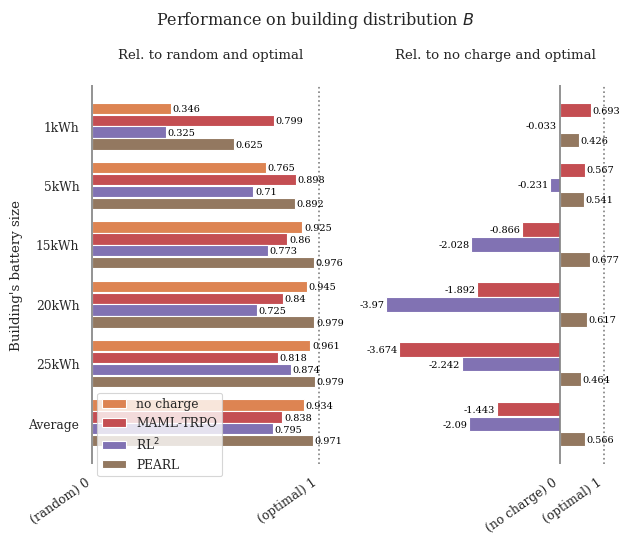

In [4]:
# Create shared plot with different relative performances

import bauwerk.utils.exp_plotting

fig, axs = plt.subplots(1, 2, figsize=[6.4, 5.5])
fig.suptitle("Performance on building distribution $B$")
bauwerk.utils.exp_plotting.create_bar_chart(env_data, "optimal","random", ax=axs[0])
bauwerk.utils.exp_plotting.create_bar_chart(env_data, "optimal","no charge", remove_keys=["random"], ax=axs[1], include_legend=False)
axs[1].set_ylabel("")
axs[1].set_yticks([])
fig.tight_layout()
fig.savefig("combined_build_distb_plot.png", dpi=300)

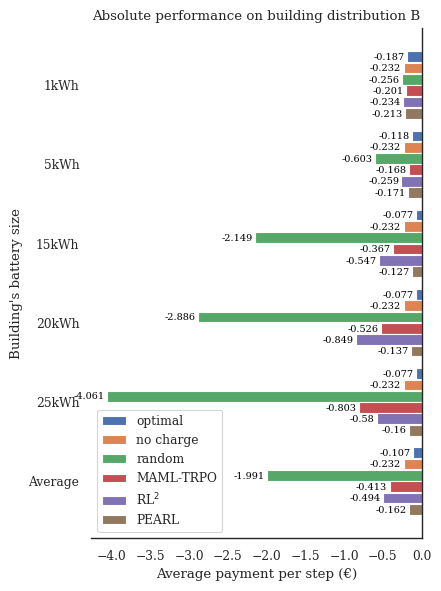

In [8]:
fig, ax = plt.subplots(figsize=(4.5, 6))
bauwerk.utils.exp_plotting.create_bar_chart(env_data=env_data,
    absolute=True, title="Absolute performance on building distribution B",
    x_label="Average payment per step (€)",
    ax=ax)
fig.tight_layout()
fig.savefig("exp_barchart_b_absolute.png", dpi=300)